In [1]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.base import RegressorMixin, TransformerMixin
from sklearn.preprocessing import PowerTransformer, QuantileTransformer, StandardScaler
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV, LinearRegression, ElasticNet, ElasticNetCV

from sklearn.compose import ColumnTransformer
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.model_selection import cross_validate, KFold
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import TimeSeriesSplit


In [2]:
# Import custom classes
from supervised_model_pipelineTW import EdaToolbox, RegressorMultiModelEvaluator

## Inspect the data

In [3]:
# Load the training data
combined_file_path = '/Users/timwillard/Desktop/group3-project2-ml/tw/combined_cities.csv'
train_full_df = pd.read_csv(combined_file_path)
train_full_df.head()

,DATE,MeanSalePrice,SalesCount,TotalTransactionValue,HomeValueIndex,HomeValueIndexSmSa,MarketTempIdx,DaysToClose,DaysOnZillow,ListingPriceCutAmt,...,PctSoldBelowList,MORTGAGE15US,MORTGAGE30US,RATE_DIFFERENCE,NUM_JOBS,GROWTH_PCT,People25PlusThousands_2019,PctHighSchoolDiploma_2019,PctBachelorsDegree_2019,CityName
0,2008-04-30,200954.0,6463.0,1.235943e+09,185168.707578,189442.061550,NaN,NaN,NaN,NaN,...,NaN,5.465,5.918,0.452,2454.9,-3.5,4414.04779,89.810682,41.859123,"ATLANTA, GA"
1,2008-05-31,203419.0,6729.0,1.317605e+09,185331.245765,188426.220342,NaN,NaN,NaN,NaN,...,NaN,5.600,6.036,0.436,2450.9,-6.2,4414.04779,89.810682,41.859123,"ATLANTA, GA"
2,2008-06-30,205746.0,7047.0,1.388670e+09,185185.095114,187437.288971,NaN,NaN,NaN,NaN,...,NaN,5.910,6.320,0.410,2442.4,-6.1,4414.04779,89.810682,41.859123,"ATLANTA, GA"
3,2008-07-31,205553.0,7086.0,1.429205e+09,184692.089305,186253.861325,NaN,NaN,NaN,NaN,...,NaN,5.972,6.426,0.454,2434.6,-6.8,4414.04779,89.810682,41.859123,"ATLANTA, GA"
4,2008-08-31,202855.0,6383.0,1.388101e+09,183376.364934,184882.815462,NaN,NaN,NaN,NaN,...,NaN,6.025,6.478,0.452,2429.3,-7.2,4414.04779,89.810682,41.859123,"ATLANTA, GA"


In [4]:
# Remove columns that are too predictive
cols_to_remove = ['HomeValueIndexSmSa', 'HomeValueIndex']
train_full_df = train_full_df.drop(cols_to_remove, axis=1)

## Create an EdaToolbox object

In [5]:
# Initialize the EdaToolbox
target_col = 'MeanSalePrice'
eda = EdaToolbox(train_full_df, target_column=target_col)

In [6]:
col_info_df = eda.gather_initial_column_info()
col_info_df.head()

,data_type,max_value_count_pct,most_frequent_value,unique_values,missing_values,missing_values_pct,top_10_values
CityName,object,0.142857,"ATLANTA, GA",7,0,0.0,"Index(['ATLANTA, GA', 'CHARLOTTE, NC', 'CINCIN..."
DATE,object,0.005128,2008-04-30,195,0,0.0,"Index(['2008-04-30', '2012-05-31', '2009-03-31..."
People25PlusThousands_2019,float64,0.142857,4414.04779,7,0,0.0,"Index([4414.04779, 1777.64019, 1418.62244, 24..."
PctHighSchoolDiploma_2019,float64,0.142857,89.810682,7,0,0.0,"Index([89.810682, 91.950313, 93.921524, 91.688..."
PctBachelorsDegree_2019,float64,0.142857,41.859123,7,0,0.0,"Index([41.859123, 39.434102, 43.323481, 49.747..."


In [7]:
eda.prune_infreq_categorical = 0.9
eda.prune_infreq_numerical = 0.95
eda.prune_pct_missing = 0.8

## First check the distribution of the target column and select an appropriate target column transformer

In [8]:
# It is not normally distributed. It has a long tail to the right. Need to try different target transformations
target_transformation_dict: dict[str, TransformerMixin] = {
    'StandardScaler': StandardScaler(),
    'PowerTransformer': PowerTransformer(standardize=False),
    'QuantileTransformer': QuantileTransformer(output_distribution='normal', n_quantiles=500, random_state=42),
}

In [9]:
# Create a dict of models for preliminary testing of target transformations
model_dict: dict[str, RegressorMixin] = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(alpha=1.0, random_state=42),
    'Lasso Regression': Lasso(alpha=1.0, random_state=42),
    'ElasticNet Regression': ElasticNet(alpha=1.0, random_state=42),
    'LassoCV': LassoCV(),
    'ElasticNetCV': ElasticNetCV(),
    'RidgeCV': RidgeCV(np.logspace(-6, 6, 25)),
    'HistGradientBoost': HistGradientBoostingRegressor(max_iter=200, random_state=42)
}


In [10]:
kf_cv = KFold(n_splits=5, shuffle=True, random_state=42)

In [11]:
# Use basic ordinal feature transformer
eda.feature_transformer = eda.get_basic_ordinal_feature_transformer()

In [12]:
# Evaluate RMSE for various regression models and target transformations with all ordinaly encoded categorical features
model_pred_cv_df = eda.analyze_target_column_transformation_predictions(target_transformation_dict, model_dict, kf_cv)
model_pred_cv_df

,Linear Regression,Ridge Regression,Lasso Regression,ElasticNet Regression,LassoCV,ElasticNetCV,RidgeCV,HistGradientBoost
StandardScaler,0.187990,0.187714,0.999761,0.854482,0.194111,0.197404,0.187769,0.094871
PowerTransformer,0.000016,0.000016,0.000088,0.000088,0.000018,0.000018,0.000016,0.000007
QuantileTransformer,0.231325,0.230997,1.013425,0.844332,0.268389,0.236215,0.231090,0.148221


In [13]:
# Evaluate RMSE for various regression models and target transformations with all ordinaly encoded categorical features without CV
model_pred_df = eda.analyze_target_column_transformation_predictions(target_transformation_dict, model_dict)
model_pred_df

,Linear Regression,Ridge Regression,Lasso Regression,ElasticNet Regression,LassoCV,ElasticNetCV,RidgeCV,HistGradientBoost
StandardScaler,0.198386,0.198408,0.979367,0.828316,0.198380,0.198517,0.198816,0.122389
PowerTransformer,0.000017,0.000017,0.000086,0.000086,0.000017,0.000017,0.000017,0.000008
QuantileTransformer,0.282388,0.282837,0.994172,0.823342,0.283308,0.283408,0.283158,0.185951


In [14]:
# Use basic OHE feature transformer
eda.feature_transformer = eda.get_basic_ohe_feature_transformer()

In [15]:
# Evaluate RMSE for various regression models and target transformations with all ordinaly encoded categorical features
model_pred_cv_df = eda.analyze_target_column_transformation_predictions(target_transformation_dict, model_dict, kf_cv)
model_pred_cv_df

,Linear Regression,Ridge Regression,Lasso Regression,ElasticNet Regression,LassoCV,ElasticNetCV,RidgeCV,HistGradientBoost
StandardScaler,0.349140,0.348842,0.999761,0.922068,0.355779,0.367631,0.348805,0.107837
PowerTransformer,0.000039,0.000039,0.000088,0.000088,0.000066,0.000066,0.000039,0.000009
QuantileTransformer,0.484765,0.484507,1.013425,0.979817,0.761519,0.815346,0.484320,0.167189


In [16]:
# Evaluate RMSE for various regression models and target transformations with all ordinaly encoded categorical features without CV
model_pred_df = eda.analyze_target_column_transformation_predictions(target_transformation_dict, model_dict)
model_pred_df

,Linear Regression,Ridge Regression,Lasso Regression,ElasticNet Regression,LassoCV,ElasticNetCV,RidgeCV,HistGradientBoost
StandardScaler,0.351929,0.351786,0.979367,0.898866,0.351642,0.351848,0.351786,0.132440
PowerTransformer,0.000039,0.000039,0.000086,0.000086,0.000039,0.000039,0.000039,0.000010
QuantileTransformer,0.505547,0.505454,0.994172,0.958972,0.505152,0.505206,0.505581,0.200542


## Set the target and feature column tranformers

* Use the PowerTransformer for the target column
* Use the basic ordinal feature transformer

In [17]:
# Looks like the CV Models perform the best with a PowerTransformer.
# NOTE: These are pretty good RMSE scores with very basic encoding and no feature selection
eda.target_transformer = PowerTransformer(standardize=False)
eda.feature_transformer = eda.get_basic_ordinal_feature_transformer()

## Prepare the data for feature selection

In [18]:
# Gather initial column information sorted by data type and max value count to check for columns with high cardinality that can be pruned
col_info_df = eda.gather_initial_column_info()
col_info_df.head()

,data_type,max_value_count_pct,most_frequent_value,unique_values,missing_values,missing_values_pct,top_10_values
CityName,object,0.142857,"ATLANTA, GA",7,0,0.0,"Index(['ATLANTA, GA', 'CHARLOTTE, NC', 'CINCIN..."
DATE,object,0.005128,2008-04-30,195,0,0.0,"Index(['2008-04-30', '2012-05-31', '2009-03-31..."
People25PlusThousands_2019,float64,0.142857,4414.04779,7,0,0.0,"Index([4414.04779, 1777.64019, 1418.62244, 24..."
PctHighSchoolDiploma_2019,float64,0.142857,89.810682,7,0,0.0,"Index([89.810682, 91.950313, 93.921524, 91.688..."
PctBachelorsDegree_2019,float64,0.142857,41.859123,7,0,0.0,"Index([41.859123, 39.434102, 43.323481, 49.747..."


In [19]:
# Set pruning thresholds on the eda object according to column data type and cardinality for this dataset
eda.prune_infreq_categorical = 0.9
eda.prune_infreq_numerical = 0.95
eda.prune_pct_missing = 0.8

## Feature analysis

In [20]:
# First check what the correlation and coefficient numbers look like
fa_df = eda.get_regression_feature_analysis_df()
fa_df.head()

Best RidgeCV alpha: 1.0 (R^2 score:  0.97)


,correlation_abs,coefficient_abs,pval,vif,PCA1_abs,PCA2_abs,total
numerical__TotalTransactionValue,0.598135,0.000031,0.035438,14.361492,0.035308,0.447155,1.080629
ordinal_date__DATE,0.755939,0.000054,0.000021,3.090963,0.052579,0.158950,0.967523
ordinal_cityname__CityName,0.606716,0.000047,0.017514,3.835799,0.114890,0.105636,0.827289
numerical__PctSoldBelowList,0.239475,0.000008,0.962366,60.514527,0.380245,0.093817,0.713545
numerical__ListingPriceCutAmt,0.324136,0.000003,0.366689,7.952464,0.341420,0.039298,0.704856


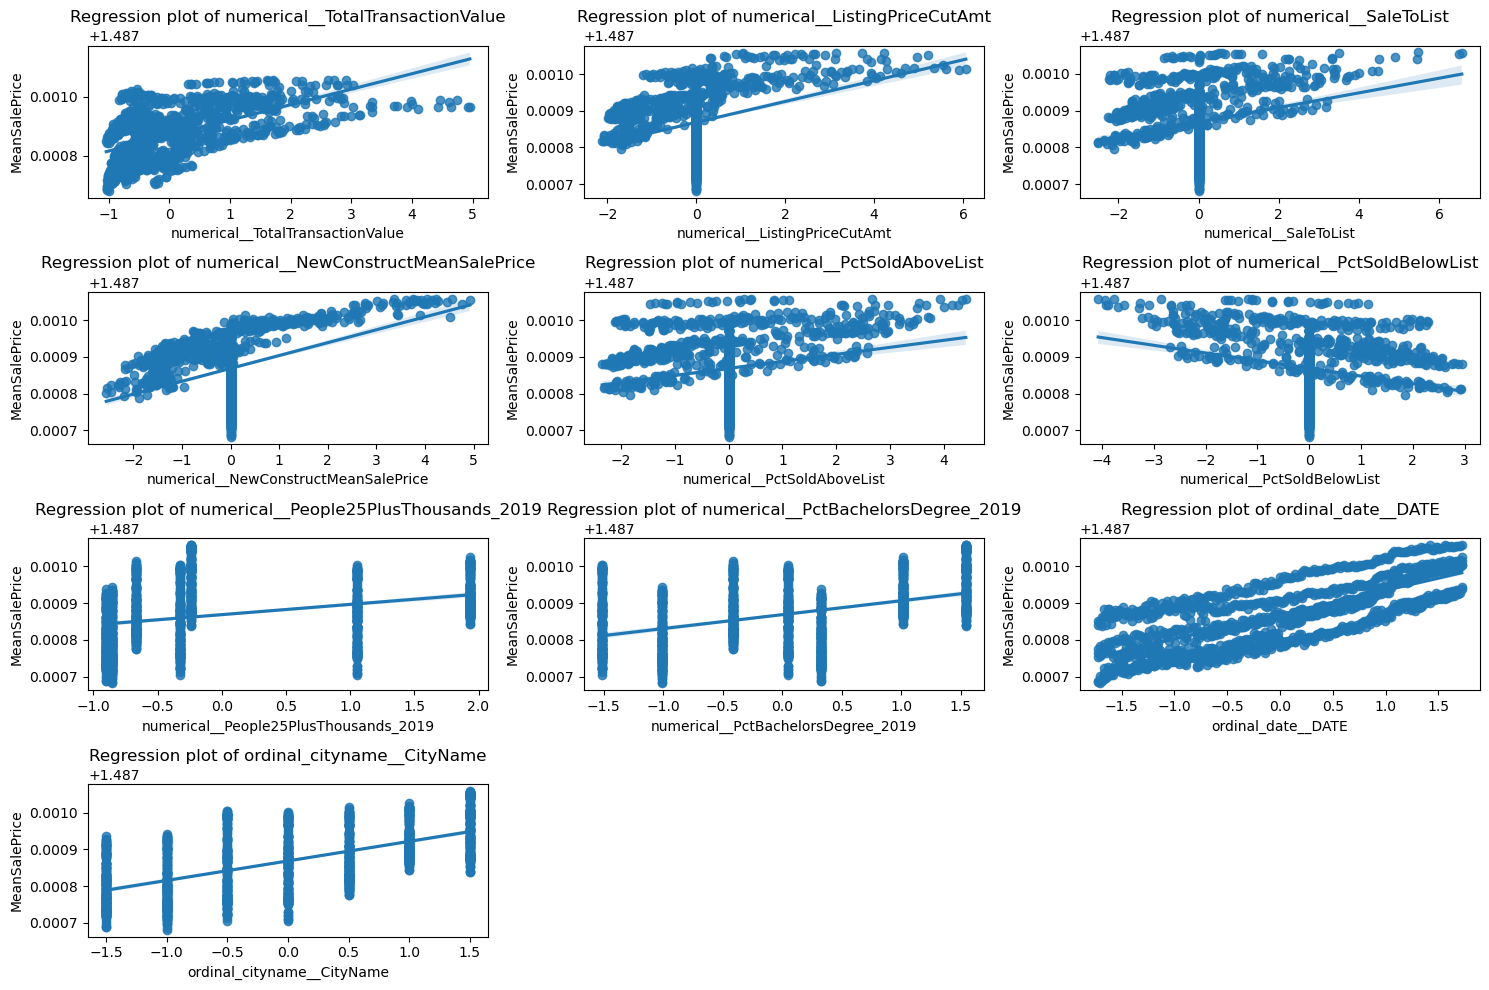

In [21]:
# Plot out the highly correlated features
eda.plot_regression_feature_correlations(corr_min=0.2)

## Perform unsupervised feature selection

Optimal number of features: 5


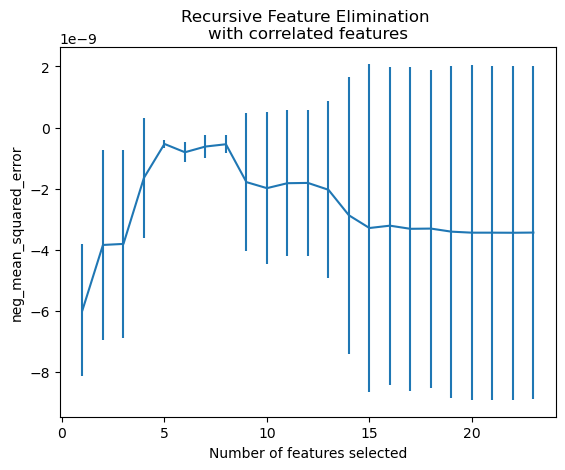

,mean_test_score,std_test_score,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,selected,ranking,feature_name
0,-5.973825e-09,2.165261e-09,-5.465490e-09,-3.775058e-09,-8.376947e-09,-3.623057e-09,-8.628574e-09,False,3,SalesCount
1,-3.841091e-09,3.094351e-09,-5.433235e-09,-6.921778e-10,-4.791845e-10,-3.848355e-09,-8.752504e-09,False,2,TotalTransactionValue
2,-3.806574e-09,3.085520e-09,-5.410153e-09,-6.637661e-10,-4.228103e-10,-3.861237e-09,-8.674902e-09,False,14,MarketTempIdx
3,-1.643274e-09,1.954915e-09,-3.910004e-10,-3.659892e-10,-4.792886e-10,-5.456365e-09,-1.523729e-09,False,19,DaysToClose
4,-5.352199e-10,1.318480e-10,-4.294484e-10,-3.840481e-10,-4.826940e-10,-7.233777e-10,-6.565317e-10,False,8,DaysOnZillow


In [22]:
# Try recursive feature elimination to find the optimal number of features for a linear regression model
regressor = LinearRegression()
rfecv_results_df = eda.perform_unsupervised_regression_rfe_feature_selection(regressor)
rfecv_results_df.head()

In [23]:
rfe_lr_selected_features = eda.get_rfe_selected_features(rfecv_results_df)
print(f"RFE LR Selected Features: {rfe_lr_selected_features}")

RFE LR Selected Features: ['MORTGAGE15US' 'MORTGAGE30US' 'RATE_DIFFERENCE' 'DATE' 'CityName']


Optimal number of features: 5


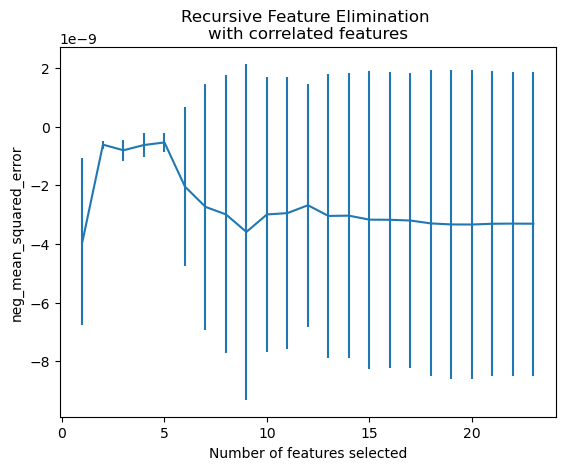

In [24]:
# Try recursive feature elimination to find the optimal number of features for a RidgeCV model
regressor = RidgeCV(alphas=np.logspace(-6, 6, num=5))
rfecv_results_df = eda.perform_unsupervised_regression_rfe_feature_selection(regressor)


In [25]:
rfe_ridge_selected_features = eda.get_rfe_selected_features(rfecv_results_df)
print(f"RFE Ridge Selected features: {rfe_ridge_selected_features}")

RFE Ridge Selected features: ['SalesCount' 'TotalTransactionValue' 'PctSoldAboveList' 'DATE' 'CityName']


In [26]:
# Try using forward SFS (SequentialFeatureSelector) to select the top 28 features
sfs_ridge_selected_features = eda.perform_unsupervised_regression_sfs_feature_selection(n_features=10)
print(f"SFS Ridge Selected Features: {sfs_ridge_selected_features}")


RidgeCV best alpha 1.0
Selected 10 features by forward sequential featureselection in 2.137 seconds
SFS Ridge Selected Features: ['SalesCount', 'TotalTransactionValue', 'DaysToClose', 'ListingPriceCutPct', 'PctListingsPriceCut', 'MORTGAGE30US', 'GROWTH_PCT', 'PctHighSchoolDiploma_2019', 'DATE', 'CityName']


In [27]:
# Remove colinear features from the list of selected features
# rfe_ridge_selected_features = [rfe_ridge_selected_features]
rfe_ridge_selected_features = list(rfe_ridge_selected_features)
#rfe_ridge_selected_features.remove('PctSoldAboveList')
#rfe_ridge_selected_features.remove('MORTGAGE15US')
rfe_ridge_selected_features

['SalesCount', 'TotalTransactionValue', 'PctSoldAboveList', 'DATE', 'CityName']

In [28]:
# Update EDA object with selected features from RFE
eda.selected_feature_list = rfe_ridge_selected_features

# Now get the list of selected ordinal columns
final_ordinal_cols = eda.get_final_ordinal_col_names(rfe_lr_selected_features)
len(final_ordinal_cols), final_ordinal_cols

(2, ['DATE', 'CityName'])

## Perform final EDA with selected features and ordinal columns

In [29]:
# Reset transformer properties to use the selected columns and ordinal columns
eda.ordinal_encoding_col_dict = {}
for col_name in final_ordinal_cols:
    eda.add_ordinal_encoding_column(col_name, None)

eda.feature_transformer = eda.create_feature_transformer()
eda.feature_transformer

ColumnTransformer(transformers=[('numerical',
                                 Pipeline(memory='named_steps',
                                          steps=[('pruner',
                                                  SimplePruner(infreq=0.95,
                                                               pct_miss=0.8)),
                                                 ('selector',
                                                  SelectedFeaturesTransformer(selected_feature_list=['SalesCount',
                                                                                                     'TotalTransactionValue',
                                                                                                     'PctSoldAboveList',
                                                                                                     'DATE',
                                                                                                     'CityName'])),
                                                 ('imputer', SimpleImputer()),
                                                 ('scaler', StandardScaler())]),
                                 Index(['SalesCount',...
                                                 ('scaler', StandardScaler())]),
                                 ['DATE']),
                                ('ordinal_cityname',
                                 Pipeline(memory='named_steps',
                                          steps=[('CityName',
                                                  OrdinalEncoder(categories=[['CINCINNATI, '
                                                                              'OH',
                                                                              'INDIANAPOLIS, '
                                                                              'IN',
                                                                              'TAMPA, '
                                                                              'FL',
                                                                              'ATLANTA, '
                                                                              'GA',
                                                                              'CHARLOTTE, '
                                                                              'NC',
                                                                              'PROVIDENCE, '
                                                                              'RI',
                                                                              'DENVER, '
                                                                              'CO']],
                                                                 encoded_missing_value=-2,
                                                                 handle_unknown='use_encoded_value',
                                                                 unknown_value=-1)),
                                                 ('scaler', StandardScaler())]),
                                 ['CityName'])])

In [30]:
# Check feature analysis to ensure we have no multicollinearity (ie. no infinite vifs)
feature_analysis_df = eda.get_regression_feature_analysis_df()
feature_analysis_df.head()

Best RidgeCV alpha: 1.0 (R^2 score:  0.96)


,correlation_abs,coefficient_abs,pval,vif,PCA1_abs,PCA2_abs,total
ordinal_cityname__CityName,0.606716,0.000047,3.058960e-07,1.364780,0.190537,0.663018,1.460318
numerical__TotalTransactionValue,0.598135,0.000028,1.456693e-05,6.798806,0.658548,0.044370,1.301081
ordinal_date__DATE,0.755939,0.000057,1.184146e-07,1.862403,0.435708,0.100450,1.292154
numerical__PctSoldAboveList,0.218508,0.000001,4.312329e-01,1.107068,0.155468,0.683869,1.057846
numerical__SalesCount,0.196533,0.000022,2.293495e-05,4.715862,0.562137,0.284029,1.042721


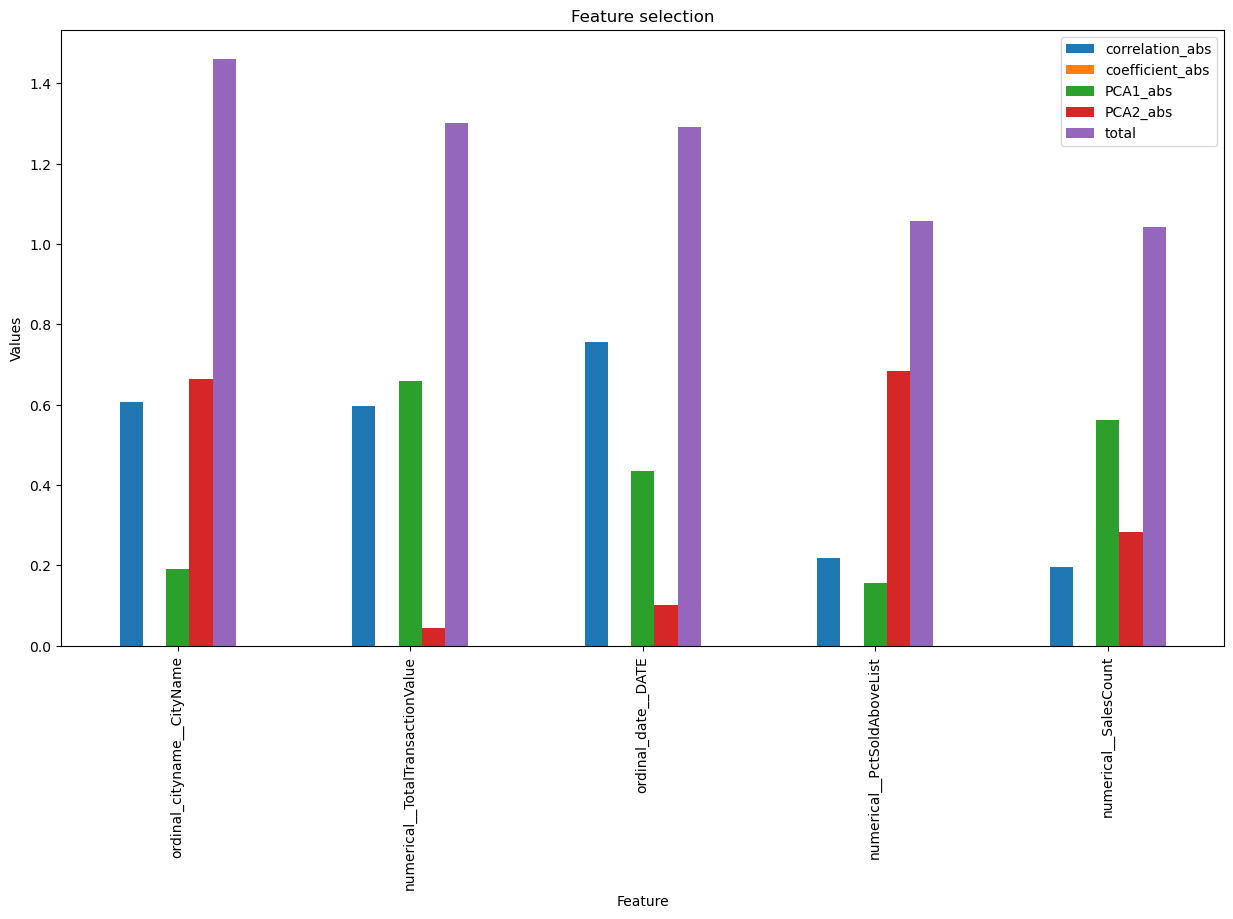

In [31]:
eda.plot_important_features(feature_analysis_df)

# Now do model analysis for multiple regression models

In [32]:
# Reload the data just to be safe
train_full_df = pd.read_csv(combined_file_path)

# Create an instance of RegressorMultiModelEvaluator and set various properties
reg = RegressorMultiModelEvaluator(train_full_df, target_column=target_col)
reg.set_column_transformer_properties(selected_feature_list=eda.selected_feature_list, ordinal_feature_list=final_ordinal_cols)
reg.set_target_column_transformer(eda.target_transformer)

In [33]:
# Create a dict of models to test
model_dict: dict[str, RegressorMixin] = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(alpha=1.0, random_state=42),
    'LassoCV': LassoCV(),
    'ElasticNetCV': ElasticNetCV(),
    'RidgeCV': RidgeCV(alphas=np.logspace(-6, 6, num=7)),
    'HistGradientBoost': HistGradientBoostingRegressor(max_iter=200, random_state=42)
}

In [34]:
# Evaluate the models
eval_df = reg.evaluate_models(model_dict)
eval_df

Number original X cols: 25
Number scaled X cols: 5


,train_r2,mse,r2,r2_adj,lr_cv_mean,lr_cv_std,time,y_pred
model_name,,,,,,,,
HistGradientBoost,0.998151,9.808011e-11,0.986772,0.986524,0.946303,0.008731,1.741639,"[1.4879212777402888, 1.48787180495549, 1.48783..."
Linear Regression,0.957132,3.898704e-10,0.947417,0.946432,0.946303,0.008731,0.004593,"[1.4879338935818185, 1.4878776120429744, 1.487..."
Ridge Regression,0.957131,3.902260e-10,0.947369,0.946383,0.946303,0.008731,0.002637,"[1.4879338339273487, 1.4878775987562503, 1.487..."
RidgeCV,0.957131,3.902260e-10,0.947369,0.946383,0.946303,0.008731,0.002385,"[1.4879338339273487, 1.4878775987562505, 1.487..."
LassoCV,0.957124,3.914612e-10,0.947202,0.946214,0.946303,0.008731,0.012794,"[1.4879339527534985, 1.4878776633092516, 1.487..."
ElasticNetCV,0.957124,3.914612e-10,0.947202,0.946214,0.946303,0.008731,0.011298,"[1.4879339527490436, 1.4878776633082393, 1.487..."


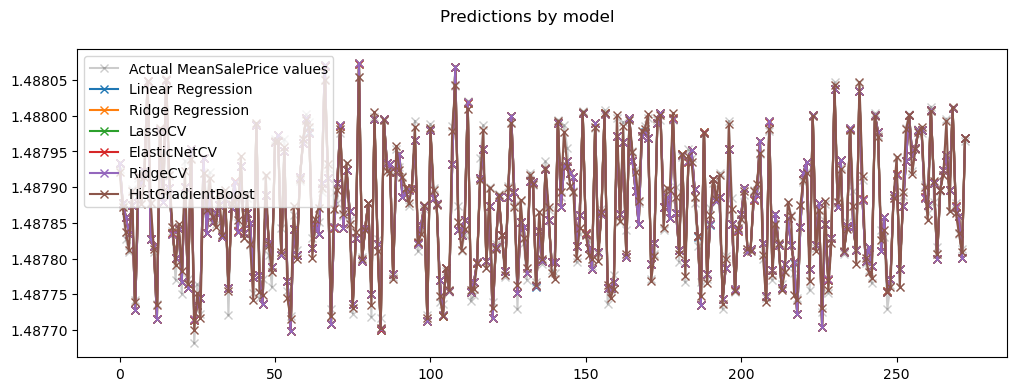

In [35]:
reg.plot_model_evaluations()

In [36]:
# Get the best model
reg.best_model_name

'HistGradientBoost'

## Now use the best model to predict on the test data

In [39]:
# Load test data from a different city
atlanta_file_path = '../Data/Clean/combined/Atlanta_combined.csv'
test_full_df = pd.read_csv(atlanta_file_path)
test_full_df.head()

,DATE,MeanSalePrice,SalesCount,TotalTransactionValue,HomeValueIndex,HomeValueIndexSmSa,MarketTempIdx,DaysToClose,DaysOnZillow,ListingPriceCutAmt,...,PctSoldBelowList,MORTGAGE15US,MORTGAGE30US,RATE_DIFFERENCE,NUM_JOBS,GROWTH_PCT,People25PlusThousands_2019,PctHighSchoolDiploma_2019,PctBachelorsDegree_2019,CityName
0,2008-04-30,200954.0,6463.0,1.235943e+09,185168.707578,189442.061550,NaN,NaN,NaN,NaN,...,NaN,5.465,5.918,0.452,2454.9,-3.5,4414.04779,89.810682,41.859123,"ATLANTA, GA"
1,2008-05-31,203419.0,6729.0,1.317605e+09,185331.245765,188426.220342,NaN,NaN,NaN,NaN,...,NaN,5.600,6.036,0.436,2450.9,-6.2,4414.04779,89.810682,41.859123,"ATLANTA, GA"
2,2008-06-30,205746.0,7047.0,1.388670e+09,185185.095114,187437.288971,NaN,NaN,NaN,NaN,...,NaN,5.910,6.320,0.410,2442.4,-6.1,4414.04779,89.810682,41.859123,"ATLANTA, GA"
3,2008-07-31,205553.0,7086.0,1.429205e+09,184692.089305,186253.861325,NaN,NaN,NaN,NaN,...,NaN,5.972,6.426,0.454,2434.6,-6.8,4414.04779,89.810682,41.859123,"ATLANTA, GA"
4,2008-08-31,202855.0,6383.0,1.388101e+09,183376.364934,184882.815462,NaN,NaN,NaN,NaN,...,NaN,6.025,6.478,0.452,2429.3,-7.2,4414.04779,89.810682,41.859123,"ATLANTA, GA"


In [40]:
# Drop target column
atlanta_actual_values = test_full_df[target_col]
test_full_df = test_full_df.drop(columns=[target_col])
test_full_df.head()

,DATE,SalesCount,TotalTransactionValue,HomeValueIndex,HomeValueIndexSmSa,MarketTempIdx,DaysToClose,DaysOnZillow,ListingPriceCutAmt,ListingPriceCutPct,...,PctSoldBelowList,MORTGAGE15US,MORTGAGE30US,RATE_DIFFERENCE,NUM_JOBS,GROWTH_PCT,People25PlusThousands_2019,PctHighSchoolDiploma_2019,PctBachelorsDegree_2019,CityName
0,2008-04-30,6463.0,1.235943e+09,185168.707578,189442.061550,NaN,NaN,NaN,NaN,NaN,...,NaN,5.465,5.918,0.452,2454.9,-3.5,4414.04779,89.810682,41.859123,"ATLANTA, GA"
1,2008-05-31,6729.0,1.317605e+09,185331.245765,188426.220342,NaN,NaN,NaN,NaN,NaN,...,NaN,5.600,6.036,0.436,2450.9,-6.2,4414.04779,89.810682,41.859123,"ATLANTA, GA"
2,2008-06-30,7047.0,1.388670e+09,185185.095114,187437.288971,NaN,NaN,NaN,NaN,NaN,...,NaN,5.910,6.320,0.410,2442.4,-6.1,4414.04779,89.810682,41.859123,"ATLANTA, GA"
3,2008-07-31,7086.0,1.429205e+09,184692.089305,186253.861325,NaN,NaN,NaN,NaN,NaN,...,NaN,5.972,6.426,0.454,2434.6,-6.8,4414.04779,89.810682,41.859123,"ATLANTA, GA"
4,2008-08-31,6383.0,1.388101e+09,183376.364934,184882.815462,NaN,NaN,NaN,NaN,NaN,...,NaN,6.025,6.478,0.452,2429.3,-7.2,4414.04779,89.810682,41.859123,"ATLANTA, GA"


In [41]:
# Make predictions with HistGradientBoost
#reg.best_model = model_dict['Linear Regression']
lr_predictions = reg.predict(test_full_df)
lr_predictions

array([186671.20283561, 191398.81849149, 198099.9998459 , 197769.35625358,
       204240.44863215, 182161.93784451, 183180.52907279, 166631.68128435,
       168045.20034454, 159241.1707132 , 156540.80205438, 153567.63750284,
       153578.20824772, 157613.20121632, 163924.20011501, 167019.42788809,
       178092.83006775, 170147.15559828, 162798.46810951, 162667.44299477,
       164411.61688288, 168915.49657724, 169877.61118264, 166506.2309677 ,
       164649.91164563, 165738.84934503, 169940.34375015, 187446.1992996 ,
       187597.79761576, 176966.59692278, 170783.78159611, 171651.67513379,
       176168.43736439, 166670.3901801 , 169434.25457442, 162462.46390962,
       163317.29304793, 166621.91080727, 165208.37652339, 173476.62246022,
       167439.83752572, 166837.49327746, 160937.41619279, 164838.48297163,
       161185.52227178, 154839.48203049, 155363.91301183, 154730.38798041,
       161741.48925316, 155509.25522479, 160414.46906701, 172453.67293892,
       164861.66834432, 1

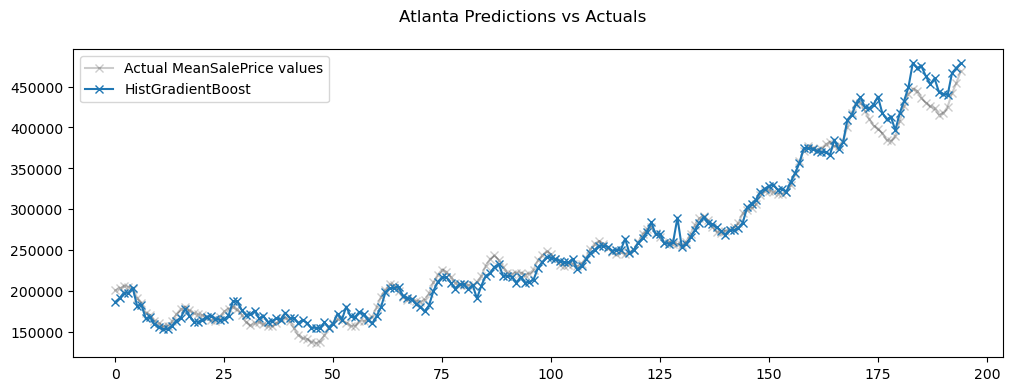

In [42]:
# Plot Actual vs Predictions
fig, ax = plt.subplots(figsize=(12, 4))
fig.suptitle("Atlanta Predictions vs Actuals")
ax.plot(
    atlanta_actual_values,
    "x-",
    alpha=0.2,
    label=f"Actual {target_col} values",
    color="black",
)
ax.plot(lr_predictions, "x-", label="HistGradientBoost")
_ = ax.legend()

In [43]:
# Load test data from Charlotte
charlotte_file_path = '../Data/Clean/combined/Charlotte_combined.csv'
test_full_df = pd.read_csv(charlotte_file_path)
test_full_df.head()

,DATE,MeanSalePrice,SalesCount,TotalTransactionValue,HomeValueIndex,HomeValueIndexSmSa,MarketTempIdx,DaysToClose,DaysOnZillow,ListingPriceCutAmt,...,PctSoldBelowList,MORTGAGE15US,MORTGAGE30US,RATE_DIFFERENCE,NUM_JOBS,GROWTH_PCT,People25PlusThousands_2019,PctHighSchoolDiploma_2019,PctBachelorsDegree_2019,CityName
0,2008-04-30,191953.0,2856.0,503313664.0,178716.688988,181743.275129,NaN,NaN,NaN,NaN,...,NaN,5.465,5.918,0.452,1027.8,-1.2,1777.64019,91.950313,39.434102,"CHARLOTTE, NC"
1,2008-05-31,195297.0,2962.0,548334302.0,179423.191080,181545.123492,NaN,NaN,NaN,NaN,...,NaN,5.600,6.036,0.436,1026.8,-2.0,1777.64019,91.950313,39.434102,"CHARLOTTE, NC"
2,2008-06-30,198585.0,2963.0,581541816.0,179464.810356,181053.563638,NaN,NaN,NaN,NaN,...,NaN,5.910,6.320,0.410,1026.1,-1.3,1777.64019,91.950313,39.434102,"CHARLOTTE, NC"
3,2008-07-31,203829.0,2845.0,595760175.0,179255.088378,180331.749481,NaN,NaN,NaN,NaN,...,NaN,5.972,6.426,0.454,1024.6,-1.1,1777.64019,91.950313,39.434102,"CHARLOTTE, NC"
4,2008-08-31,204174.0,2530.0,568197072.0,178753.302909,179487.604132,NaN,NaN,NaN,NaN,...,NaN,6.025,6.478,0.452,1024.7,-0.7,1777.64019,91.950313,39.434102,"CHARLOTTE, NC"


In [44]:
# Drop target column
charlotte_file_path_actual_values = test_full_df[target_col]
test_full_df = test_full_df.drop(columns=[target_col])
test_full_df.head()

,DATE,SalesCount,TotalTransactionValue,HomeValueIndex,HomeValueIndexSmSa,MarketTempIdx,DaysToClose,DaysOnZillow,ListingPriceCutAmt,ListingPriceCutPct,...,PctSoldBelowList,MORTGAGE15US,MORTGAGE30US,RATE_DIFFERENCE,NUM_JOBS,GROWTH_PCT,People25PlusThousands_2019,PctHighSchoolDiploma_2019,PctBachelorsDegree_2019,CityName
0,2008-04-30,2856.0,503313664.0,178716.688988,181743.275129,NaN,NaN,NaN,NaN,NaN,...,NaN,5.465,5.918,0.452,1027.8,-1.2,1777.64019,91.950313,39.434102,"CHARLOTTE, NC"
1,2008-05-31,2962.0,548334302.0,179423.191080,181545.123492,NaN,NaN,NaN,NaN,NaN,...,NaN,5.600,6.036,0.436,1026.8,-2.0,1777.64019,91.950313,39.434102,"CHARLOTTE, NC"
2,2008-06-30,2963.0,581541816.0,179464.810356,181053.563638,NaN,NaN,NaN,NaN,NaN,...,NaN,5.910,6.320,0.410,1026.1,-1.3,1777.64019,91.950313,39.434102,"CHARLOTTE, NC"
3,2008-07-31,2845.0,595760175.0,179255.088378,180331.749481,NaN,NaN,NaN,NaN,NaN,...,NaN,5.972,6.426,0.454,1024.6,-1.1,1777.64019,91.950313,39.434102,"CHARLOTTE, NC"
4,2008-08-31,2530.0,568197072.0,178753.302909,179487.604132,NaN,NaN,NaN,NaN,NaN,...,NaN,6.025,6.478,0.452,1024.7,-0.7,1777.64019,91.950313,39.434102,"CHARLOTTE, NC"


In [45]:
# Make predictions with HistGradientBoost
#reg.best_model = model_dict['Linear Regression']
lr_predictions = reg.predict(test_full_df)
lr_predictions

array([180568.18220063, 183452.38261806, 192712.59895917, 202153.5764374 ,
       203896.18449562, 182641.52249214, 184152.04485601, 166631.68128435,
       168045.20034454, 159241.1707132 , 156540.80205438, 156540.80205438,
       156540.80205438, 160950.57679162, 166898.14055737, 167616.47866059,
       177533.61577368, 168386.39997341, 162733.99955376, 164365.42328909,
       169097.75502185, 168915.49657724, 169877.61118264, 167408.95511608,
       166514.56110261, 166566.69209833, 177422.19112946, 188728.89781199,
       186367.69529945, 184144.15364235, 179447.53505916, 177987.43656536,
       176168.43736439, 166670.3901801 , 169434.25457442, 164648.85501797,
       166881.46575797, 168180.50623868, 171358.57358228, 178798.55972685,
       176485.26022661, 175622.67436879, 167977.68429524, 168643.39821677,
       166576.74417262, 158325.88945674, 156540.80205438, 155824.49717502,
       168100.63475586, 167641.38936275, 181674.57190246, 203725.01417948,
       189707.32178317, 1

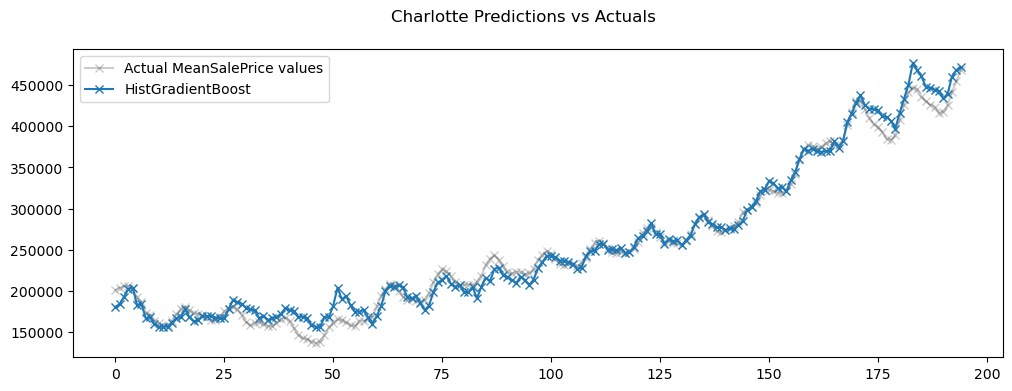

In [46]:
# Plot Actual vs Predictions
fig, ax = plt.subplots(figsize=(12, 4))
fig.suptitle("Charlotte Predictions vs Actuals")
ax.plot(
    atlanta_actual_values,
    "x-",
    alpha=0.2,
    label=f"Actual {target_col} values",
    color="black",
)
ax.plot(lr_predictions, "x-", label="HistGradientBoost")
_ = ax.legend()

In [47]:
# Load test data from Cincinnati
cincinnati_file_path = '../Data/Clean/combined/Cincinnati_combined.csv'
test_full_df = pd.read_csv(cincinnati_file_path)
test_full_df.head()

,DATE,MeanSalePrice,SalesCount,TotalTransactionValue,HomeValueIndex,HomeValueIndexSmSa,MarketTempIdx,DaysToClose,DaysOnZillow,ListingPriceCutAmt,...,PctSoldBelowList,MORTGAGE15US,MORTGAGE30US,RATE_DIFFERENCE,NUM_JOBS,GROWTH_PCT,People25PlusThousands_2019,PctHighSchoolDiploma_2019,PctBachelorsDegree_2019,CityName
0,2008-04-30,155566.0,1939.0,278000302.0,154159.712821,157939.052238,NaN,NaN,NaN,NaN,...,NaN,5.465,5.918,0.452,1047.0,-1.8,1418.62244,93.921524,43.323481,"CINCINNATI, OH"
1,2008-05-31,158474.0,2190.0,315975507.0,154896.973753,157678.462221,NaN,NaN,NaN,NaN,...,NaN,5.600,6.036,0.436,1045.6,-1.8,1418.62244,93.921524,43.323481,"CINCINNATI, OH"
2,2008-06-30,164199.0,2286.0,352017758.0,155768.803669,157332.615865,NaN,NaN,NaN,NaN,...,NaN,5.910,6.320,0.410,1041.2,-1.3,1418.62244,93.921524,43.323481,"CINCINNATI, OH"
3,2008-07-31,167422.0,2224.0,374100404.0,156376.821297,157143.826684,NaN,NaN,NaN,NaN,...,NaN,5.972,6.426,0.454,1045.1,-0.6,1418.62244,93.921524,43.323481,"CINCINNATI, OH"
4,2008-08-31,166249.0,2193.0,371690060.0,155577.849578,156653.274461,NaN,NaN,NaN,NaN,...,NaN,6.025,6.478,0.452,1043.8,-0.6,1418.62244,93.921524,43.323481,"CINCINNATI, OH"


In [48]:
# Drop target column
cincinnati_file_path_actual_values = test_full_df[target_col]
test_full_df = test_full_df.drop(columns=[target_col])
test_full_df.head()

,DATE,SalesCount,TotalTransactionValue,HomeValueIndex,HomeValueIndexSmSa,MarketTempIdx,DaysToClose,DaysOnZillow,ListingPriceCutAmt,ListingPriceCutPct,...,PctSoldBelowList,MORTGAGE15US,MORTGAGE30US,RATE_DIFFERENCE,NUM_JOBS,GROWTH_PCT,People25PlusThousands_2019,PctHighSchoolDiploma_2019,PctBachelorsDegree_2019,CityName
0,2008-04-30,1939.0,278000302.0,154159.712821,157939.052238,NaN,NaN,NaN,NaN,NaN,...,NaN,5.465,5.918,0.452,1047.0,-1.8,1418.62244,93.921524,43.323481,"CINCINNATI, OH"
1,2008-05-31,2190.0,315975507.0,154896.973753,157678.462221,NaN,NaN,NaN,NaN,NaN,...,NaN,5.600,6.036,0.436,1045.6,-1.8,1418.62244,93.921524,43.323481,"CINCINNATI, OH"
2,2008-06-30,2286.0,352017758.0,155768.803669,157332.615865,NaN,NaN,NaN,NaN,NaN,...,NaN,5.910,6.320,0.410,1041.2,-1.3,1418.62244,93.921524,43.323481,"CINCINNATI, OH"
3,2008-07-31,2224.0,374100404.0,156376.821297,157143.826684,NaN,NaN,NaN,NaN,NaN,...,NaN,5.972,6.426,0.454,1045.1,-0.6,1418.62244,93.921524,43.323481,"CINCINNATI, OH"
4,2008-08-31,2193.0,371690060.0,155577.849578,156653.274461,NaN,NaN,NaN,NaN,NaN,...,NaN,6.025,6.478,0.452,1043.8,-0.6,1418.62244,93.921524,43.323481,"CINCINNATI, OH"


In [49]:
# Make predictions with HistGradientBoost
#reg.best_model = model_dict['Linear Regression']
lr_predictions = reg.predict(test_full_df)
lr_predictions

array([182276.65748812, 182957.62338504, 197233.50746678, 202095.82998012,
       211476.13948404, 188471.03191261, 177151.78169116, 166631.68128435,
       168045.20034454, 159241.1707132 , 156540.80205438, 156540.80205438,
       153578.20824772, 157684.18762122, 156463.4771529 , 170454.38278746,
       179498.86926055, 173687.89614234, 160535.13096476, 161857.53730933,
       165475.27837593, 168915.49657724, 169877.61118264, 166733.5922613 ,
       161237.64325697, 158689.78716161, 172016.57439898, 198391.79018636,
       187110.041391  , 184144.15364235, 179447.53505916, 177987.43656536,
       176168.43736439, 166670.3901801 , 169434.25457442, 162588.73545918,
       163188.01516764, 166621.48048041, 168636.56575127, 179955.61034348,
       188764.35883942, 178020.12668531, 166493.6404094 , 168643.39821677,
       166576.74417262, 158325.88945674, 156540.80205438, 155824.49717502,
       167228.32560515, 163561.94399931, 168609.33041748, 199431.07841487,
       174382.88508829, 1

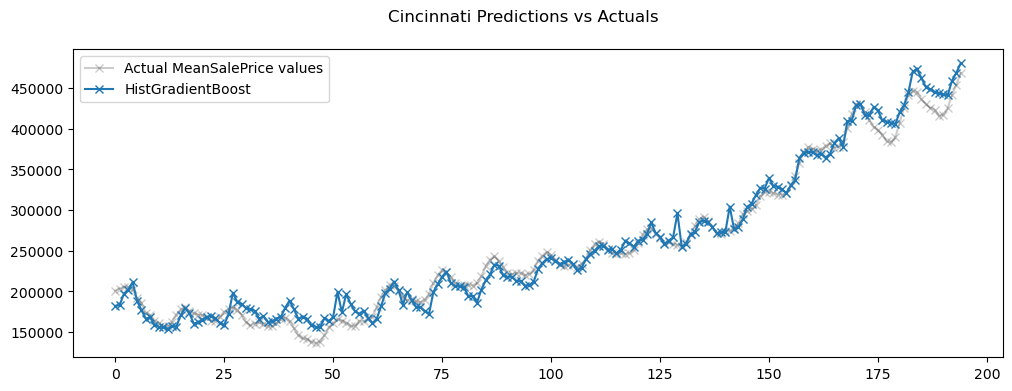

In [50]:
# Plot Actual vs Predictions
fig, ax = plt.subplots(figsize=(12, 4))
fig.suptitle("Cincinnati Predictions vs Actuals")
ax.plot(
    atlanta_actual_values,
    "x-",
    alpha=0.2,
    label=f"Actual {target_col} values",
    color="black",
)
ax.plot(lr_predictions, "x-", label="HistGradientBoost")
_ = ax.legend()

In [51]:
# Load test data from Cincinnati
denver_file_path = '../Data/Clean/combined/Denver_combined.csv'
test_full_df = pd.read_csv(denver_file_path)
test_full_df.head()

,DATE,MeanSalePrice,SalesCount,TotalTransactionValue,HomeValueIndex,HomeValueIndexSmSa,MarketTempIdx,DaysToClose,DaysOnZillow,ListingPriceCutAmt,...,PctSoldBelowList,MORTGAGE15US,MORTGAGE30US,RATE_DIFFERENCE,NUM_JOBS,GROWTH_PCT,People25PlusThousands_2019,PctHighSchoolDiploma_2019,PctBachelorsDegree_2019,CityName
0,2008-04-30,245069.0,4305.0,9.275848e+08,239786.727396,243635.279120,NaN,NaN,NaN,NaN,...,NaN,5.465,5.918,0.452,1259.0,1.0,2434.5429,91.688128,49.747029,"DENVER, CO"
1,2008-05-31,242919.0,4779.0,1.043794e+09,240755.620219,242719.130794,NaN,NaN,NaN,NaN,...,NaN,5.600,6.036,0.436,1256.8,-1.0,2434.5429,91.688128,49.747029,"DENVER, CO"
2,2008-06-30,245529.0,4789.0,1.136320e+09,241296.223700,241952.165191,NaN,NaN,NaN,NaN,...,NaN,5.910,6.320,0.410,1258.2,-0.6,2434.5429,91.688128,49.747029,"DENVER, CO"
3,2008-07-31,247607.0,4922.0,1.195890e+09,240843.494803,240801.464621,NaN,NaN,NaN,NaN,...,NaN,5.972,6.426,0.454,1256.1,-1.0,2434.5429,91.688128,49.747029,"DENVER, CO"
4,2008-08-31,246384.0,4333.0,1.154412e+09,239424.931087,239672.270501,NaN,NaN,NaN,NaN,...,NaN,6.025,6.478,0.452,1256.2,-0.2,2434.5429,91.688128,49.747029,"DENVER, CO"


In [52]:
# Drop target column
denver_file_path_actual_values = test_full_df[target_col]
test_full_df = test_full_df.drop(columns=[target_col])
test_full_df.head()

,DATE,SalesCount,TotalTransactionValue,HomeValueIndex,HomeValueIndexSmSa,MarketTempIdx,DaysToClose,DaysOnZillow,ListingPriceCutAmt,ListingPriceCutPct,...,PctSoldBelowList,MORTGAGE15US,MORTGAGE30US,RATE_DIFFERENCE,NUM_JOBS,GROWTH_PCT,People25PlusThousands_2019,PctHighSchoolDiploma_2019,PctBachelorsDegree_2019,CityName
0,2008-04-30,4305.0,9.275848e+08,239786.727396,243635.279120,NaN,NaN,NaN,NaN,NaN,...,NaN,5.465,5.918,0.452,1259.0,1.0,2434.5429,91.688128,49.747029,"DENVER, CO"
1,2008-05-31,4779.0,1.043794e+09,240755.620219,242719.130794,NaN,NaN,NaN,NaN,NaN,...,NaN,5.600,6.036,0.436,1256.8,-1.0,2434.5429,91.688128,49.747029,"DENVER, CO"
2,2008-06-30,4789.0,1.136320e+09,241296.223700,241952.165191,NaN,NaN,NaN,NaN,NaN,...,NaN,5.910,6.320,0.410,1258.2,-0.6,2434.5429,91.688128,49.747029,"DENVER, CO"
3,2008-07-31,4922.0,1.195890e+09,240843.494803,240801.464621,NaN,NaN,NaN,NaN,NaN,...,NaN,5.972,6.426,0.454,1256.1,-1.0,2434.5429,91.688128,49.747029,"DENVER, CO"
4,2008-08-31,4333.0,1.154412e+09,239424.931087,239672.270501,NaN,NaN,NaN,NaN,NaN,...,NaN,6.025,6.478,0.452,1256.2,-0.2,2434.5429,91.688128,49.747029,"DENVER, CO"


In [53]:
# Make predictions with HistGradientBoost
#reg.best_model = model_dict['Linear Regression']
lr_predictions = reg.predict(test_full_df)
lr_predictions

array([171279.72565121, 170475.55412421, 189555.94828831, 190196.69285658,
       187068.31959617, 159530.91823704, 158336.49024009, 163488.82815808,
       163241.6151839 , 159241.1707132 , 156540.80205438, 153219.76318922,
       155133.50967   , 156894.2604868 , 157073.81575945, 151510.00688385,
       166255.97992759, 162577.06420465, 157776.61424319, 160976.98685484,
       165391.41959151, 168915.49657724, 169877.61118264, 161912.85242651,
       157073.81575945, 151169.98518036, 161872.64904324, 184995.79019665,
       186367.69529945, 184144.15364235, 179447.53505916, 177987.43656536,
       176168.43736439, 166670.3901801 , 169434.25457442, 162663.50867848,
       160832.48115777, 164300.64326759, 161029.7007713 , 171930.63267353,
       167436.83469469, 172115.36542596, 163619.02294696, 168643.39821677,
       166576.74417262, 158325.88945674, 156540.80205438, 157486.70277566,
       160838.09496626, 155122.76405042, 166372.03883136, 174894.29062851,
       172308.19857508, 1

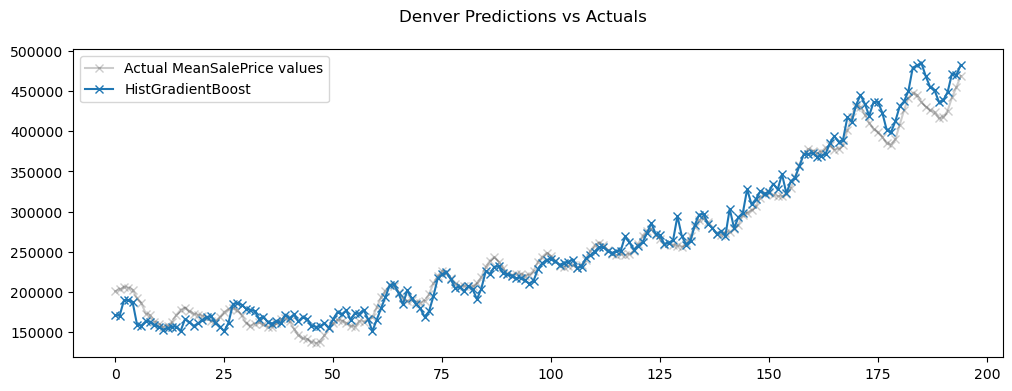

In [54]:
# Plot Actual vs Predictions
fig, ax = plt.subplots(figsize=(12, 4))
fig.suptitle("Denver Predictions vs Actuals")
ax.plot(
    atlanta_actual_values,
    "x-",
    alpha=0.2,
    label=f"Actual {target_col} values",
    color="black",
)
ax.plot(lr_predictions, "x-", label="HistGradientBoost")
_ = ax.legend()

In [55]:
# Load test data from Cincinnati
indianapolis_file_path = '../Data/Clean/combined/Indianapolis_combined.csv'
test_full_df = pd.read_csv(indianapolis_file_path)
test_full_df.head()

,DATE,MeanSalePrice,SalesCount,TotalTransactionValue,HomeValueIndex,HomeValueIndexSmSa,MarketTempIdx,DaysToClose,DaysOnZillow,ListingPriceCutAmt,...,PctSoldBelowList,MORTGAGE15US,MORTGAGE30US,RATE_DIFFERENCE,NUM_JOBS,GROWTH_PCT,People25PlusThousands_2019,PctHighSchoolDiploma_2019,PctBachelorsDegree_2019,CityName
0,2008-04-30,149771.0,2151.0,291536100.0,131097.969553,133638.666266,NaN,NaN,NaN,NaN,...,NaN,5.465,5.918,0.452,956.7,0.2,1488.97601,90.664284,36.279526,"INDIANAPOLIS, IN"
1,2008-05-31,151827.0,2430.0,331352084.0,132148.045670,133520.379815,NaN,NaN,NaN,NaN,...,NaN,5.600,6.036,0.436,958.9,0.5,1488.97601,90.664284,36.279526,"INDIANAPOLIS, IN"
2,2008-06-30,154789.0,2438.0,362561539.0,132930.782306,133559.343193,NaN,NaN,NaN,NaN,...,NaN,5.910,6.320,0.410,958.2,0.3,1488.97601,90.664284,36.279526,"INDIANAPOLIS, IN"
3,2008-07-31,157222.0,2457.0,383886935.0,133222.597102,133449.285413,NaN,NaN,NaN,NaN,...,NaN,5.972,6.426,0.454,961.2,1.5,1488.97601,90.664284,36.279526,"INDIANAPOLIS, IN"
4,2008-08-31,154119.0,2309.0,370365976.0,133037.483397,133164.069995,NaN,NaN,NaN,NaN,...,NaN,6.025,6.478,0.452,959.9,0.3,1488.97601,90.664284,36.279526,"INDIANAPOLIS, IN"


In [56]:
# Drop target column
indianapolis_file_path_actual_values = test_full_df[target_col]
test_full_df = test_full_df.drop(columns=[target_col])
test_full_df.head()

,DATE,SalesCount,TotalTransactionValue,HomeValueIndex,HomeValueIndexSmSa,MarketTempIdx,DaysToClose,DaysOnZillow,ListingPriceCutAmt,ListingPriceCutPct,...,PctSoldBelowList,MORTGAGE15US,MORTGAGE30US,RATE_DIFFERENCE,NUM_JOBS,GROWTH_PCT,People25PlusThousands_2019,PctHighSchoolDiploma_2019,PctBachelorsDegree_2019,CityName
0,2008-04-30,2151.0,291536100.0,131097.969553,133638.666266,NaN,NaN,NaN,NaN,NaN,...,NaN,5.465,5.918,0.452,956.7,0.2,1488.97601,90.664284,36.279526,"INDIANAPOLIS, IN"
1,2008-05-31,2430.0,331352084.0,132148.045670,133520.379815,NaN,NaN,NaN,NaN,NaN,...,NaN,5.600,6.036,0.436,958.9,0.5,1488.97601,90.664284,36.279526,"INDIANAPOLIS, IN"
2,2008-06-30,2438.0,362561539.0,132930.782306,133559.343193,NaN,NaN,NaN,NaN,NaN,...,NaN,5.910,6.320,0.410,958.2,0.3,1488.97601,90.664284,36.279526,"INDIANAPOLIS, IN"
3,2008-07-31,2457.0,383886935.0,133222.597102,133449.285413,NaN,NaN,NaN,NaN,NaN,...,NaN,5.972,6.426,0.454,961.2,1.5,1488.97601,90.664284,36.279526,"INDIANAPOLIS, IN"
4,2008-08-31,2309.0,370365976.0,133037.483397,133164.069995,NaN,NaN,NaN,NaN,NaN,...,NaN,6.025,6.478,0.452,959.9,0.3,1488.97601,90.664284,36.279526,"INDIANAPOLIS, IN"


In [57]:
# Make predictions with HistGradientBoost
#reg.best_model = model_dict['Linear Regression']
lr_predictions = reg.predict(test_full_df)
lr_predictions

array([182174.13849249, 179109.04226786, 192711.63124526, 196969.98061229,
       200312.39246872, 186463.41963823, 182644.47790248, 166631.68128435,
       168045.20034454, 159241.1707132 , 156540.80205438, 156540.80205438,
       153567.63750284, 157542.33821777, 160857.47652638, 170510.06801732,
       174516.94114859, 177652.12236007, 159134.58631167, 161352.53607374,
       164411.61688288, 168915.49657724, 169877.61118264, 167095.68778371,
       161604.35474045, 158969.8644518 , 178116.27890702, 198287.94951898,
       183099.33067322, 182414.48523746, 179447.53505916, 177987.43656536,
       176168.43736439, 166670.3901801 , 169434.25457442, 162588.73545918,
       162740.90264919, 165518.01703115, 166145.10695415, 185130.45063479,
       179747.99402362, 182142.55743479, 168095.84296508, 168643.39821677,
       166576.74417262, 158325.88945674, 156540.80205438, 156255.82344372,
       166320.9310019 , 163561.94399931, 164983.32776243, 199769.22248624,
       184934.18165601, 1

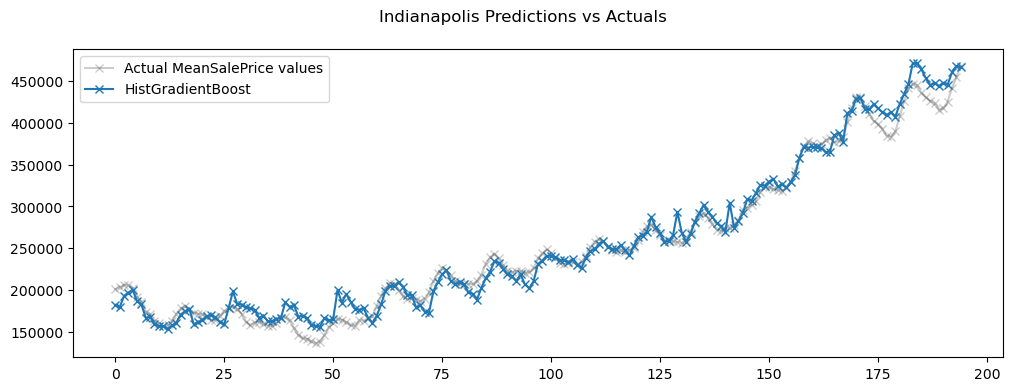

In [58]:
# Plot Actual vs Predictions
fig, ax = plt.subplots(figsize=(12, 4))
fig.suptitle("Indianapolis Predictions vs Actuals")
ax.plot(
    atlanta_actual_values,
    "x-",
    alpha=0.2,
    label=f"Actual {target_col} values",
    color="black",
)
ax.plot(lr_predictions, "x-", label="HistGradientBoost")
_ = ax.legend()

In [59]:
# Load test data from Cincinnati
providence_file_path = '../Data/Clean/combined/Providence_combined.csv'
test_full_df = pd.read_csv(providence_file_path)
test_full_df.head()

,DATE,MeanSalePrice,SalesCount,TotalTransactionValue,HomeValueIndex,HomeValueIndexSmSa,MarketTempIdx,DaysToClose,DaysOnZillow,ListingPriceCutAmt,...,PctSoldBelowList,MORTGAGE15US,MORTGAGE30US,RATE_DIFFERENCE,NUM_JOBS,GROWTH_PCT,People25PlusThousands_2019,PctHighSchoolDiploma_2019,PctBachelorsDegree_2019,CityName
0,2008-04-30,279826.0,1094.0,268863782.0,275076.989042,286193.357806,NaN,NaN,NaN,NaN,...,NaN,5.465,5.918,0.452,578.1,-0.9,5757.78597,93.596408,46.976027,"PROVIDENCE, RI"
1,2008-05-31,287299.0,1278.0,324116899.0,274598.055307,283995.275711,NaN,NaN,NaN,NaN,...,NaN,5.600,6.036,0.436,576.2,-1.3,5757.78597,93.596408,46.976027,"PROVIDENCE, RI"
2,2008-06-30,291347.0,1439.0,371228964.0,274776.048804,281705.331555,NaN,NaN,NaN,NaN,...,NaN,5.910,6.320,0.410,574.6,-1.6,5757.78597,93.596408,46.976027,"PROVIDENCE, RI"
3,2008-07-31,294474.0,1368.0,401046568.0,273315.038401,279020.136289,NaN,NaN,NaN,NaN,...,NaN,5.972,6.426,0.454,572.9,-1.7,5757.78597,93.596408,46.976027,"PROVIDENCE, RI"
4,2008-08-31,292317.0,1240.0,394628893.0,271264.245006,275929.894315,NaN,NaN,NaN,NaN,...,NaN,6.025,6.478,0.452,570.9,-1.8,5757.78597,93.596408,46.976027,"PROVIDENCE, RI"


In [60]:
# Drop target column
providence_file_path_actual_values = test_full_df[target_col]
test_full_df = test_full_df.drop(columns=[target_col])
test_full_df.head()

,DATE,SalesCount,TotalTransactionValue,HomeValueIndex,HomeValueIndexSmSa,MarketTempIdx,DaysToClose,DaysOnZillow,ListingPriceCutAmt,ListingPriceCutPct,...,PctSoldBelowList,MORTGAGE15US,MORTGAGE30US,RATE_DIFFERENCE,NUM_JOBS,GROWTH_PCT,People25PlusThousands_2019,PctHighSchoolDiploma_2019,PctBachelorsDegree_2019,CityName
0,2008-04-30,1094.0,268863782.0,275076.989042,286193.357806,NaN,NaN,NaN,NaN,NaN,...,NaN,5.465,5.918,0.452,578.1,-0.9,5757.78597,93.596408,46.976027,"PROVIDENCE, RI"
1,2008-05-31,1278.0,324116899.0,274598.055307,283995.275711,NaN,NaN,NaN,NaN,NaN,...,NaN,5.600,6.036,0.436,576.2,-1.3,5757.78597,93.596408,46.976027,"PROVIDENCE, RI"
2,2008-06-30,1439.0,371228964.0,274776.048804,281705.331555,NaN,NaN,NaN,NaN,NaN,...,NaN,5.910,6.320,0.410,574.6,-1.6,5757.78597,93.596408,46.976027,"PROVIDENCE, RI"
3,2008-07-31,1368.0,401046568.0,273315.038401,279020.136289,NaN,NaN,NaN,NaN,NaN,...,NaN,5.972,6.426,0.454,572.9,-1.7,5757.78597,93.596408,46.976027,"PROVIDENCE, RI"
4,2008-08-31,1240.0,394628893.0,271264.245006,275929.894315,NaN,NaN,NaN,NaN,NaN,...,NaN,6.025,6.478,0.452,570.9,-1.8,5757.78597,93.596408,46.976027,"PROVIDENCE, RI"


In [61]:
# Make predictions with HistGradientBoost
#reg.best_model = model_dict['Linear Regression']
lr_predictions = reg.predict(test_full_df)
lr_predictions

array([181764.92593571, 185890.26699821, 198090.69407909, 211563.85687588,
       216278.23732057, 199848.37989608, 187714.92948051, 167467.81748304,
       168045.20034454, 159241.1707132 , 156540.80205438, 156540.80205438,
       156540.80205438, 157466.23974467, 152540.81055761, 155944.01682837,
       171409.34409845, 179453.60105698, 158460.74309579, 155752.93954621,
       178207.64351436, 168915.49657724, 169877.61118264, 166506.2309677 ,
       161604.35474045, 159451.79103114, 166104.19134898, 202741.58388518,
       197755.9569064 , 176963.63201317, 177251.06945549, 175622.67436879,
       169956.58665224, 166670.3901801 , 169434.25457442, 162507.30765207,
       163210.21272827, 164300.64326759, 161968.0717973 , 165750.22869474,
       172862.06130941, 182719.75911519, 170910.74040314, 164253.09925566,
       159064.98518992, 158325.88945674, 156540.80205438, 157120.61657628,
       165694.22457143, 160692.34957389, 160310.62249836, 181330.22835255,
       172564.18344863, 1

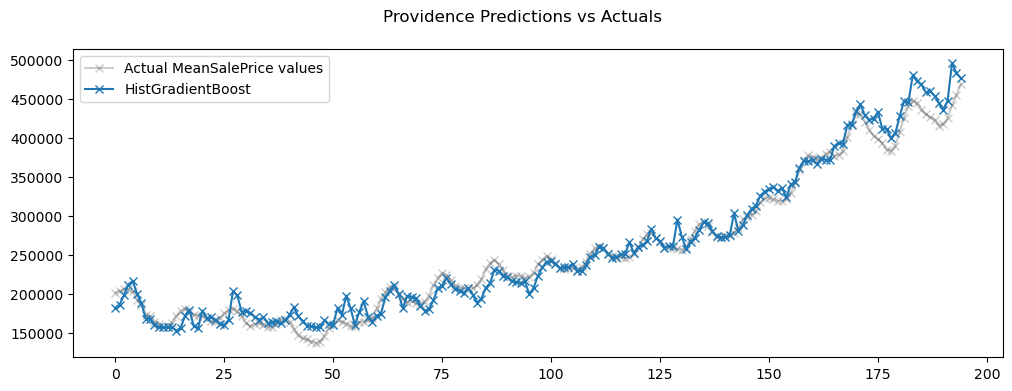

In [62]:
# Plot Actual vs Predictions
fig, ax = plt.subplots(figsize=(12, 4))
fig.suptitle("Providence Predictions vs Actuals")
ax.plot(
    atlanta_actual_values,
    "x-",
    alpha=0.2,
    label=f"Actual {target_col} values",
    color="black",
)
ax.plot(lr_predictions, "x-", label="HistGradientBoost")
_ = ax.legend()

In [63]:
# Load test data from Cincinnati
tamoa_file_path = '../Data/Clean/combined/Tampa_combined.csv'
test_full_df = pd.read_csv(providence_file_path)
test_full_df.head()

,DATE,MeanSalePrice,SalesCount,TotalTransactionValue,HomeValueIndex,HomeValueIndexSmSa,MarketTempIdx,DaysToClose,DaysOnZillow,ListingPriceCutAmt,...,PctSoldBelowList,MORTGAGE15US,MORTGAGE30US,RATE_DIFFERENCE,NUM_JOBS,GROWTH_PCT,People25PlusThousands_2019,PctHighSchoolDiploma_2019,PctBachelorsDegree_2019,CityName
0,2008-04-30,279826.0,1094.0,268863782.0,275076.989042,286193.357806,NaN,NaN,NaN,NaN,...,NaN,5.465,5.918,0.452,578.1,-0.9,5757.78597,93.596408,46.976027,"PROVIDENCE, RI"
1,2008-05-31,287299.0,1278.0,324116899.0,274598.055307,283995.275711,NaN,NaN,NaN,NaN,...,NaN,5.600,6.036,0.436,576.2,-1.3,5757.78597,93.596408,46.976027,"PROVIDENCE, RI"
2,2008-06-30,291347.0,1439.0,371228964.0,274776.048804,281705.331555,NaN,NaN,NaN,NaN,...,NaN,5.910,6.320,0.410,574.6,-1.6,5757.78597,93.596408,46.976027,"PROVIDENCE, RI"
3,2008-07-31,294474.0,1368.0,401046568.0,273315.038401,279020.136289,NaN,NaN,NaN,NaN,...,NaN,5.972,6.426,0.454,572.9,-1.7,5757.78597,93.596408,46.976027,"PROVIDENCE, RI"
4,2008-08-31,292317.0,1240.0,394628893.0,271264.245006,275929.894315,NaN,NaN,NaN,NaN,...,NaN,6.025,6.478,0.452,570.9,-1.8,5757.78597,93.596408,46.976027,"PROVIDENCE, RI"


In [64]:
# Drop target column
tampa_file_path_actual_values = test_full_df[target_col]
test_full_df = test_full_df.drop(columns=[target_col])
test_full_df.head()

,DATE,SalesCount,TotalTransactionValue,HomeValueIndex,HomeValueIndexSmSa,MarketTempIdx,DaysToClose,DaysOnZillow,ListingPriceCutAmt,ListingPriceCutPct,...,PctSoldBelowList,MORTGAGE15US,MORTGAGE30US,RATE_DIFFERENCE,NUM_JOBS,GROWTH_PCT,People25PlusThousands_2019,PctHighSchoolDiploma_2019,PctBachelorsDegree_2019,CityName
0,2008-04-30,1094.0,268863782.0,275076.989042,286193.357806,NaN,NaN,NaN,NaN,NaN,...,NaN,5.465,5.918,0.452,578.1,-0.9,5757.78597,93.596408,46.976027,"PROVIDENCE, RI"
1,2008-05-31,1278.0,324116899.0,274598.055307,283995.275711,NaN,NaN,NaN,NaN,NaN,...,NaN,5.600,6.036,0.436,576.2,-1.3,5757.78597,93.596408,46.976027,"PROVIDENCE, RI"
2,2008-06-30,1439.0,371228964.0,274776.048804,281705.331555,NaN,NaN,NaN,NaN,NaN,...,NaN,5.910,6.320,0.410,574.6,-1.6,5757.78597,93.596408,46.976027,"PROVIDENCE, RI"
3,2008-07-31,1368.0,401046568.0,273315.038401,279020.136289,NaN,NaN,NaN,NaN,NaN,...,NaN,5.972,6.426,0.454,572.9,-1.7,5757.78597,93.596408,46.976027,"PROVIDENCE, RI"
4,2008-08-31,1240.0,394628893.0,271264.245006,275929.894315,NaN,NaN,NaN,NaN,NaN,...,NaN,6.025,6.478,0.452,570.9,-1.8,5757.78597,93.596408,46.976027,"PROVIDENCE, RI"


In [65]:
# Make predictions with HistGradientBoost
#reg.best_model = model_dict['Linear Regression']
lr_predictions = reg.predict(test_full_df)
lr_predictions

array([181764.92593571, 185890.26699821, 198090.69407909, 211563.85687588,
       216278.23732057, 199848.37989608, 187714.92948051, 167467.81748304,
       168045.20034454, 159241.1707132 , 156540.80205438, 156540.80205438,
       156540.80205438, 157466.23974467, 152540.81055761, 155944.01682837,
       171409.34409845, 179453.60105698, 158460.74309579, 155752.93954621,
       178207.64351436, 168915.49657724, 169877.61118264, 166506.2309677 ,
       161604.35474045, 159451.79103114, 166104.19134898, 202741.58388518,
       197755.9569064 , 176963.63201317, 177251.06945549, 175622.67436879,
       169956.58665224, 166670.3901801 , 169434.25457442, 162507.30765207,
       163210.21272827, 164300.64326759, 161968.0717973 , 165750.22869474,
       172862.06130941, 182719.75911519, 170910.74040314, 164253.09925566,
       159064.98518992, 158325.88945674, 156540.80205438, 157120.61657628,
       165694.22457143, 160692.34957389, 160310.62249836, 181330.22835255,
       172564.18344863, 1

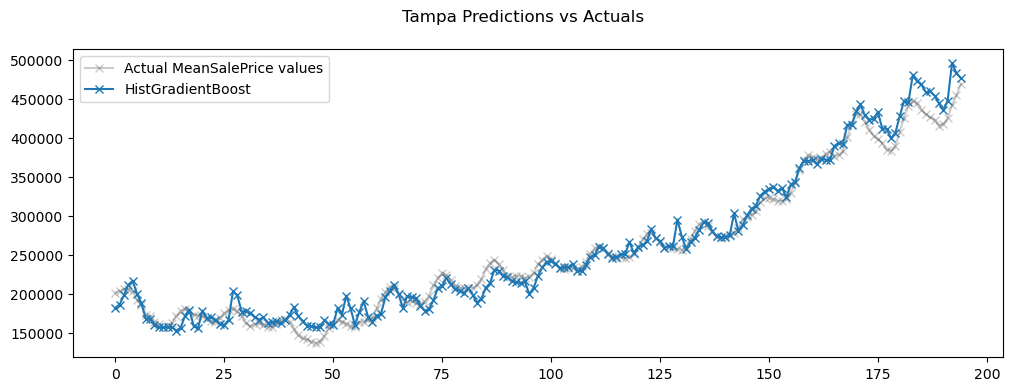

In [66]:
# Plot Actual vs Predictions
fig, ax = plt.subplots(figsize=(12, 4))
fig.suptitle("Tampa Predictions vs Actuals")
ax.plot(
    atlanta_actual_values,
    "x-",
    alpha=0.2,
    label=f"Actual {target_col} values",
    color="black",
)
ax.plot(lr_predictions, "x-", label="HistGradientBoost")
_ = ax.legend()